# Week 12 Discussion: NanoGPT: A Decoder-only Transformer

## Preview of final assignment:

[Kaggle competition](https://www.kaggle.com/competitions/sp24-tamu-csce-633-600-machine-learning)

## Objectives


Transformers are a revolutionary class of deep learning models that have had a profound impact on natural language processing (NLP) and various other domains in artificial intelligence. Introduced by Vaswani et al. in their 2017 paper "**Attention is All You Need**," transformers have quickly become the de facto architecture for many NLP tasks due to their remarkable performance and versatility.

Transformers rely on a mechanism called *self-attention* to weigh the importance of different words in a sequence when processing it. Unlike earlier sequential models like recurrent neural networks (RNNs) and long short-term memory networks (LSTMs), transformers can process the **entire sequence** simultaneously, making them highly parallelizable and efficient.

The architecture of a transformer consists of an **encoder** and a **decoder**, each composed of multiple layers of self-attention mechanisms and feed-forward neural networks. During training, the model learns to encode input sequences into high-dimensional representations and decode them to generate output sequences, all while attending to relevant parts of the input and output.

One of the key advantages of transformers is their ability to capture long-range dependencies in sequences, which was a challenge for previous models like RNNs. This capability makes transformers well-suited for tasks requiring **understanding of context over large distances**, such as language translation, text summarization, sentiment analysis, and question answering.

Decoder-only transformers, also known as autoregressive transformers, are a variant of the transformer architecture that consists only of decoder layers without encoder layers. Unlike the standard transformer architecture, which includes both encoder and decoder components, decoder-only transformers are primarily used for tasks where the model generates sequences autoregressively, such as **language modeling, text generation, and sequence-to-sequence tasks where the entire input is available during training.**

This week, we will try to develop a miniature GPT model, specifically a decoder-only transformer, entirely from **scratch**. We will explore the various components that constitute its structure.

Then we will apply this model to a segment of the literary work attributed to Shakespeare, aiming to **generate text reminiscent of his style**.

Hence, our agenda for the week includes the following:

1. **Processing** and exploring the "TinyShakespeare" dataset and devising appropriate data representations tailored to our objectives.

2. **Building** the transformer: creating attention heads, using them to form attention blocks, and leveraging them to construct a GPT-style language model.

3. Writing a **training** loop to train our GPT model.

4. Applying our trained model to **generating** text similar to Shakespearean prose.

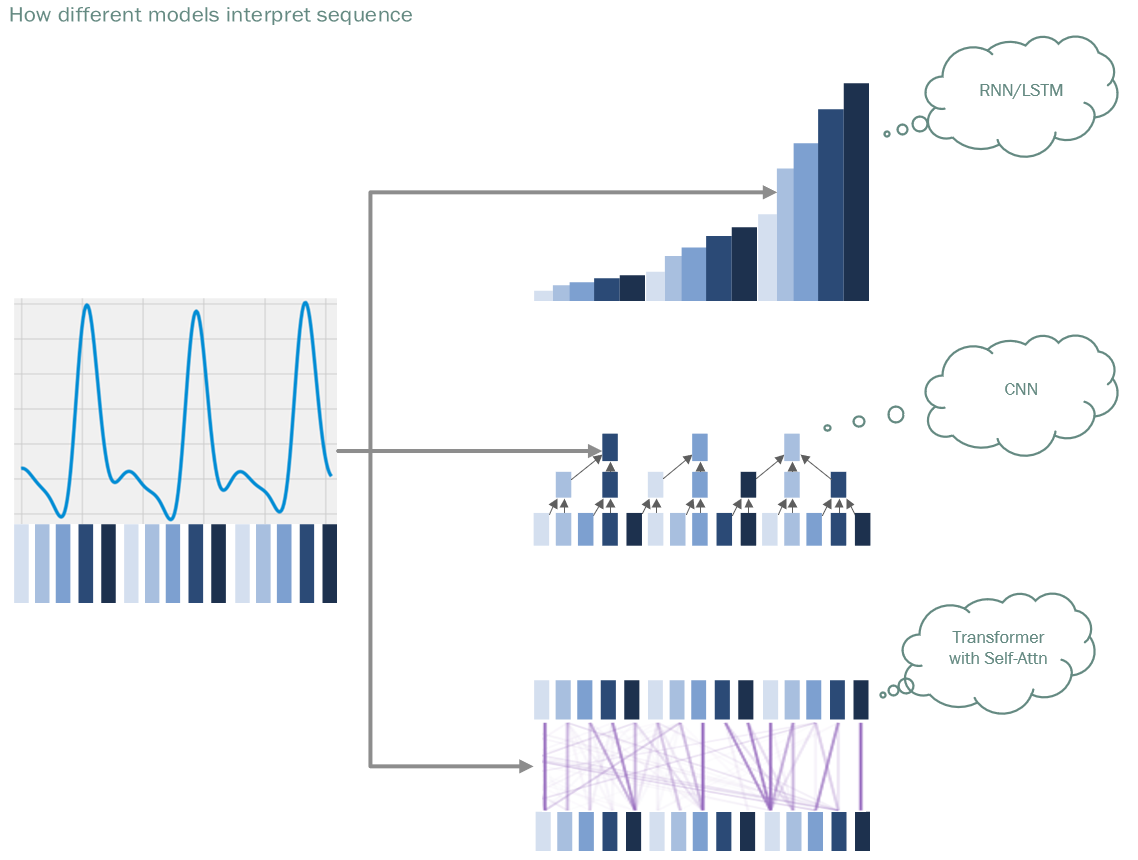


## Sources

This discussion is based on the following references:
<br>
https://www.youtube.com/watch?v=kCc8FmEb1nY&t=1s
<br>
https://github.com/karpathy/ng-video-lecture/tree/master

## 1. Exploring "TinyShakespeare" and adapting it for use

The TinyShakespeare dataset consists of 40,000 lines of Shakespeare from a variety of Shakespeare's plays.

As the first step, let us download the dataset:

In [1]:
import requests

text = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").content.decode("utf-8")

Now let us look at a few lines of the text:


In [2]:
print (text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


One of the initial stages in text processing involves tokenization, which entails segmenting a text, such as a sentence or paragraph, into individual units known as "tokens."

While many applications utilize sub-word components, in this case, we adopt **character-level tokenization**. Essentially, each character is regarded as a distinct token.

In the process of tokenization, we create a mapping from tokens to integer, so each token will then be representated by the corresponding integer. This integer representation subsequently helps in embedding such tokens into vectors.

To create a mapping from characters to integers and vice versa, let's first get the set of all characters observed:

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

Now we create a mapping from characters to integers and vice versa:

In [4]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

Let's look at what these dictionaries look like:


In [5]:
print (stoi)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [6]:
print (itos)

{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i', 48: 'j', 49: 'k', 50: 'l', 51: 'm', 52: 'n', 53: 'o', 54: 'p', 55: 'q', 56: 'r', 57: 's', 58: 't', 59: 'u', 60: 'v', 61: 'w', 62: 'x', 63: 'y', 64: 'z'}


We can also create functions `encode()` and `decode()` that take a list of strings/integers as inputs and convert them to their corresponding integer/string representation.

In [7]:
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

Example usage:

In [8]:
encoded_arr = encode('I love transformers!')
print(encoded_arr)

[21, 1, 50, 53, 60, 43, 1, 58, 56, 39, 52, 57, 44, 53, 56, 51, 43, 56, 57, 2]


In [9]:
decode(encoded_arr)

'I love transformers!'

Now we split the data into training and validation sets.

- Encode the text, which is a large stream of characters, to a stream of integers by using `encode()`
- Create a `torch.tensor` out of the integer stream
- Split the integer stream into training and validation sets

In [10]:
import torch

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # 90% will be train, 10% val
train_data = data[:n]
val_data = data[n:]

Let's look at the training data:

In [11]:
train_data

tensor([18, 47, 56,  ..., 43, 56, 43])

How can such a data, which is a stream, be used for our modeling?

For a simpler example, let's first assume our stream of integers is from 0 to 10.


In [12]:
example_data = torch.tensor(range(10))
print (example_data)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


The decoder in the transformer works in an autoregressive fashion - it looks at the previous tokens, and predicts the next token. The maximum number of tokens we look back is determined by `block_size`.

We assume `block_size` = 5. Then we can start at an index and use the next `block_size` tokens in the stream to create corresponding input-output pairs.

Let's see this in an example where we start at index 0 and extract samples.

In [13]:
block_size = 5
processed_x = torch.stack([example_data[i:i+block_size]     for i in [0]])
processed_y = torch.stack([example_data[i+1:i+block_size+1] for i in [0]])

Printing the corresponding pair will make things be more intuitive:

In [14]:
for x, y in zip(processed_x, processed_y):
    print (x, y)

tensor([0, 1, 2, 3, 4]) tensor([1, 2, 3, 4, 5])


Above you can see the input (left) and the label (right). It should be interpreted as follows:

[0] -> [1]

[0, 1] -> [2]

[0, 1, 2] -> [3]

[0, 1, 2, 3] -> [4]

[0, 1, 2, 3, 4] -> [5]


So as shown, we are extracting several training samples from our stream, where each at most `block_size` (here 5) consequitive tokens are used as input features, and the next token is the output label.

We put this functionality in the `get_batch` function below. This function can be used to get a batch of samples from both training and validation datasets. Also, on top of what we just described about extracting samples from the data, it performs two additional steps, one before the sample extraction and one after:

- The extraction of training samples is randomized. As mentioned earlier, we retrieved `block_size` consecutive samples. However, the following function requires an input `batch_size`, which determines the number of consecutive training samples to be extracted. It's important to note that the function's output consists of `batch_size` sets of `block_size` consecutive samples, totaling `batch_size` times `block_size` training samples in all. The starting indices for extraction are randomly chosen for each span.
- Once samples are extracted, before returning, it moves the data to a device of choice, which could be a GPU.

In [ ]:
def get_batch(split, batch_size, device):
    # generate a small batch of data of inputs x and targets y
    if split == 'example':
        data = example_data
    elif split == 'train':
        data = train_data
    else:
        data = val_data

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

As an example, we can run this function and get:


In [ ]:
x, y = get_batch('example', batch_size = 6, device = 'cpu')
print (x)
print (y)
print (x.shape)
print (y.shape)

tensor([[0, 1, 2, 3, 4],
        [2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4],
        [4, 5, 6, 7, 8],
        [2, 3, 4, 5, 6]])
tensor([[1, 2, 3, 4, 5],
        [3, 4, 5, 6, 7],
        [2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5],
        [5, 6, 7, 8, 9],
        [3, 4, 5, 6, 7]])
torch.Size([6, 5])
torch.Size([6, 5])


## 2. Building the transformer


Let's now build the attention head for our transformer. This attention head consists of:

- Creating matrices K, Q, and V and using them for transforming the input to keys, queries, and values
- Using the queries and keys to measure similarities, then applying the mask so each token only attends to tokens before it
- Transforming the similiarities to coefficients, and using them to get a weighted average of the values and compute the transformed representation for each token.


Before explaining how the attention head needs to be implemented, let's explore what the input data to it should look like. The data we have seen so far is tokenized, but not embedded.

Transformers work with embedded tokens, rather than tokens themselves. Embedding is usually done as follows:

- A large table is created with $m$ rows and $n$ columns
- Each of the $m$ rows corresponds to a token and the corresponding $n$ entries in the row are the embedding of the token in $\mathbb{R}^n$

Now converting tokens to integers should make more sense, as we use the corresponding integers to index the embedding table.


Let's create a small embedding table suitable for our example dataset. We use the Pytorch implementation:


In [ ]:
import torch.nn as nn
embedding_dim = 2
emb = nn.Embedding(num_embeddings=10, embedding_dim=embedding_dim)

This creates a table with 10 rows (for up to 10 tokens) and 2 columns (they will be embedded in $\mathbb{R}^n$).


Remember that the example training data that we created was:


In [ ]:
x

tensor([[0, 1, 2, 3, 4],
        [2, 3, 4, 5, 6],
        [1, 2, 3, 4, 5],
        [0, 1, 2, 3, 4],
        [4, 5, 6, 7, 8],
        [2, 3, 4, 5, 6]])

with shape:


In [ ]:
print (x.shape)

torch.Size([6, 5])


Where 6 is the `batch_size` and 5 is the `block_size`. Now if we apply the embedding `emb` we created above to it, we would get:


In [ ]:
embedded = emb(x)
print (embedded[:2])

tensor([[[ 0.5153, -1.9655],
         [ 0.8182,  0.1513],
         [-0.6104, -0.8311],
         [-1.0738,  1.0989],
         [ 0.6540,  1.4406]],

        [[-0.6104, -0.8311],
         [-1.0738,  1.0989],
         [ 0.6540,  1.4406],
         [ 0.0896, -0.6489],
         [-1.1687, -0.3135]]], grad_fn=<SliceBackward0>)


With shape:


In [ ]:
print (embedded.shape)

torch.Size([6, 5, 2])


To print the shapes side by side:


In [ ]:
print (x.shape, embedded.shape)

torch.Size([6, 5]) torch.Size([6, 5, 2])


As can be seen, the embedded data has an extra dimension which is the embedding dimensionality. Therefore, the data is of the shape:

`batch_size` $\times$ `block_size` $\times$ `embedding dimension`


#### Creating the attention head


Knowing what the data looks like, we can proceed to create transforms for keys, queries, and values, which are essentially implemented as matrices. They will be matrices of size `embedding_dim` $\times$ `head_size` since the embeddings are right multiplied by such matrices to produce new vectors of dimension `head_size`:


In [ ]:
head_size = 4
key   = nn.Linear(embedding_dim, head_size, bias=False)
query = nn.Linear(embedding_dim, head_size, bias=False)
value = nn.Linear(embedding_dim, head_size, bias=False)

We get keys and queries for our input data by simply passing the embedded input through the modules `key` and `query` created above:


In [ ]:
k = key(embedded)
q = query(embedded)

Let's check the sizes:


In [ ]:
print (f'input shape: {embedded.shape}')
print (f'keys shape: {k.shape}')
print (f'queries shape: {q.shape}')

input shape: torch.Size([6, 5, 2])
keys shape: torch.Size([6, 5, 4])
queries shape: torch.Size([6, 5, 4])


So we see above that the input is 6 batches, each of length 5, of two dimensional embeddings. Each of such embeddings will then be projected into four dimensional keys ans queries.


Within each batch, we are interested in computing the attention scores. Remember that we have the formula:

$$
Softmax(\frac{QK^T}{\sqrt{d_k}})V
$$


We first calculate $\frac{QK^T}{\sqrt{d_k}}$. We do that by the following line of code:


In [ ]:
wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
print (wei.shape)

torch.Size([6, 5, 5])


In the code above, we transposed the keys by `transpose(-2,-1)`. The reason is that we wanted to swap the last (embedding) and one to the last (block) dimensions.


Let's see what the attention weights look like for a single batch:


In [ ]:
print (wei[0,:,:])

tensor([[-0.8133, -0.2037, -0.0867,  0.6987,  0.2758],
        [-0.2744, -0.0687, -0.0293,  0.2357,  0.0931],
        [-0.0185, -0.0047, -0.0019,  0.0160,  0.0062],
        [ 0.7634,  0.1912,  0.0814, -0.6557, -0.2589],
        [ 0.1909,  0.0479,  0.0203, -0.1640, -0.0647]],
       grad_fn=<SliceBackward0>)


As can be seen, all tokens within the block are attending to all the others. But in the decoder, each token should only attend to the previous tokens. Therefore, we replace the similarity of the tokens that are not allowed to attend to each other. We do that by using a mask:


In [ ]:
mask = torch.tril(torch.ones(5, 5))
print (mask)

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


We use this lower triangular mask and put negative infinity in the attention matrix wherever this mask is zero:


In [ ]:
wei = wei.masked_fill(mask == 0, float('-inf'))

The attention matrix in the first batch now looks like:


In [ ]:
print (wei[0,:,:])

tensor([[-0.8133,    -inf,    -inf,    -inf,    -inf],
        [-0.2744, -0.0687,    -inf,    -inf,    -inf],
        [-0.0185, -0.0047, -0.0019,    -inf,    -inf],
        [ 0.7634,  0.1912,  0.0814, -0.6557,    -inf],
        [ 0.1909,  0.0479,  0.0203, -0.1640, -0.0647]],
       grad_fn=<SliceBackward0>)


Being one step closer to computing $Softmax(\frac{QK^T}{\sqrt{d_k}})V$, we now compute the softmax:


In [ ]:
from torch.nn import functional as F

wei = F.softmax(wei, dim=-1)
print (wei[0, :, :])

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4488, 0.5512, 0.0000, 0.0000, 0.0000],
        [0.3300, 0.3346, 0.3355, 0.0000, 0.0000],
        [0.4325, 0.2441, 0.2187, 0.1046, 0.0000],
        [0.2389, 0.2071, 0.2014, 0.1675, 0.1850]], grad_fn=<SliceBackward0>)


Now the choice of negative infinity for masked values makes more sense. Since it would translate to 0 after applying softmax.


Finally, $Softmax(\frac{QK^T}{\sqrt{d_k}})V$ is computed by multiplying the weights by the values:


In [ ]:
v = value(embedded)
out = wei @ v
print (out.shape)

torch.Size([6, 5, 4])


We came full circle and finished the implementation of our attention head! You must now recognize the elements in the implementation below:


In [ ]:
n_embd = 384
dropout = 0.2

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

#### Creating multihead attention


This module is relatively easy to digest, as we create a class `MultiHeadAttention` that can contain several attention heads:


In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

#### Creating multi-layer perceptron


Here's the implementation of a feed forward layer, as will be later used in place of MLP in the transformer:


In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

#### Creating a transformer block


This puts all we developed before together to create the transformer block. The code is self-explanatory:


In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

#### Finally, creating a GPT language model


This module is large, let us talk about it part by part:


##### Initializer


In [ ]:
def __init__(self):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd) # final layer norm
    self.lm_head = nn.Linear(n_embd, vocab_size)

- Embeddings: We have discussed the embedding table before. We define two embedding tables, one for tokens, as talked about, and one for the positions of tokens within the block.

- Blocks: Several transformer blocks to later be applied one after another

- The rest we have seen before


##### Forward method


Below we see the forward method. Notice that an input to this function is `idx` which is the data after tokenization, not yet embedded. The function also accepts `targets` to compute loss in case it is provided.

The operations are self-explanatory, we have seen them before.


In [ ]:
def forward(self, idx, targets=None):
    B, T = idx.shape

    # idx and targets are both (B,T) tensor of integers
    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C)
    x = self.blocks(x) # (B,T,C)
    x = self.ln_f(x) # (B,T,C)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
        loss = None
    else:
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)
        loss = F.cross_entropy(logits, targets)

    return logits, loss

##### Text generate method


The function `generate` is used to generate new text. It is called once the model is fully trained. It takes the following inputs:

- `idx`: The context, the already generated text it needs to extend. In this case, we only provide new line as the start of the sentence.
- `max_new_tokens`: The maximum number of new token it generates.

The code can be seen below:


In [ ]:
def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits, loss = self(idx_cond)
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

For `max_new_tokens` iterations:

1. Crop the indeces to only include at most `block_size` tokens
2. Get predictions on next tokens using the trained model
3. Only keep the next token predictions at the last time step, last token in the block
4. Transform logits into probability using softmax
5. Sample from the distribution given by softmax
6. Concatenate the new token to the previous ones


Putting these all together, we get:


In [ ]:
n_head = 6
n_layer = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

## 3. Training loop


Let's start from defining the model:


In [ ]:
model = GPTLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

10.692545 M parameters


Now we can define the optimizer:


In [ ]:
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

And finally we write the training loop we have seen before:


In [ ]:
from tqdm.notebook import tqdm # visualize training

max_iters = 5000
eval_interval = 500
eval_iters = 200
batch_size = 64

@torch.no_grad() # decorator
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


for iter in tqdm(range(max_iters)):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', batch_size, device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 4.2777, val loss 4.2808
step 500: train loss 2.2858, val loss 2.3011
step 1000: train loss 2.1910, val loss 2.2191
step 1500: train loss 2.1366, val loss 2.2011
step 2000: train loss 2.0738, val loss 2.1642
step 2500: train loss 2.0537, val loss 2.1256
step 3000: train loss 2.0121, val loss 2.1120
step 3500: train loss 2.0038, val loss 2.1111
step 4000: train loss 1.9780, val loss 2.1006
step 4500: train loss 1.9774, val loss 2.0796
step 4999: train loss 1.9571, val loss 2.0763


## 4. Generating Shakespeare-like prose


Let's start by creating a context consisting of new line and then feed that to the model:


In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Hy moring loves not thy not, the thone.

RADWery complow ta for me cure my sounceed a sucled,
If in is off guar for:
Seir, male, when on ourfre'd grovers the is and ditay.
That king vill i't:
Are my self the sagai: your bosne.

But in ber the leatting and beeoroa sufie ye aris, peapand.

Altatly than am noth wurble a to doth these mean
Weelly.

Wers ke
witle makes:
AUlme your fail?

Pend themold of it the strue,
Award:
I me,
If alaser ab:
And no shame well misales of my his and love,
Aleang.

CL


In this discussion, we accomplished the following:

1. Explored the "TinyShakespeare" dataset and discussed how to make it usable for our training purposes.

2. Building the model: created attention heads, used them to form attention blocks, and then used all of them to construct a GPT-style language model.

3. Trained our GPT model.

4. Employed our trained model to generate text similar to Shakespearean prose, utilizing the capabilities we have developed.


Hope you have enjoyed this lesson!
